# 머신러닝 돌리기 (기본)
### history-stations
- 새로운 변수 추가, 튜닝 등 진행하지 않음

In [1]:
!pip install pymongo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 19.5 MB/s eta 0:00:00


#### 라이브러리 준비

In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import json_normalize
import numpy as np

from prophet import Prophet
import holidays

from datetime import datetime, timedelta
now = datetime.now()

import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

#### config 파일 업로드

In [4]:
from google.colab import files

# 파일 업로드
uploaded = files.upload()

Saving config.txt to config.txt


#### config.txt 파일에서 MongoDB 정보 가져오기

In [5]:
# config.txt 파일에서 MongoDB 정보 읽기
config = {}

# config.txt 파일을 읽어서 정보 가져오기
with open('config.txt', 'r') as file:
    for line in file:
        # 줄에서 공백을 제거하고 '=' 기준으로 나누어 키-값 형태로 저장
        key, value = line.strip().split('=')
        config[key] = value

# config.txt에서 가져온 정보로 MongoDB 연결
mongo_uri = config.get('MONGO_URI')
db_pw = int(config.get('PW'))
collection_name = config.get('COLLECTION_NAME')

#### 방문자수 데이터 데이터 프레임 변환

In [6]:
from pymongo import MongoClient

# 데이터가 저장된 MongoDB의 주소
client = MongoClient(mongo_uri, db_pw)

# db를 저장하기
db = client.crawling

collection = db[collection_name]

# collection에 저장된 데이터를 데이터프레임으로 변환 및 저장
rows = collection.find()
history_stations = []
for row in rows:
    history_stations.append(row)

history_stations = pd.DataFrame(history_stations)

#### 그룹화된 충전소 데이터 데이터 프레임 변환

In [7]:
from pymongo import MongoClient

# 데이터가 저장된 MongoDB의 주소
client = MongoClient(mongo_uri, db_pw)

# db를 저장하기
db = client.crawling

collection = db['grouped-chargers']

# collection에 저장된 데이터를 데이터프레임으로 변환 및 저장
rows = collection.find()
grouped_chargers = []
for row in rows:
    grouped_chargers.append(row)

grouped_chargers = pd.DataFrame(grouped_chargers)

#### 머신러닝 코드 RandomForestRegressor

In [ ]:
def run_ml(i):
    df_h = pd.DataFrame(history_stations['history'][i]) # history_chargers의 i번째 history 가져오기

    # 변수 생성 (주말, 월, 일, 시간, 분) #########################
    df_h['weekday'] = df_h['time'].dt.weekday
    df_h['month'] = df_h['time'].dt.month
    df_h['day'] = df_h['time'].dt.day
    df_h['hour'] = df_h['time'].dt.hour
    df_h['minute'] = df_h['time'].dt.minute

    # 변수 생성 (공휴일)
    kr_holidays = holidays.KR()
    df_h['holiday'] = df_h.time.apply(lambda x: 1 if x in kr_holidays else 0)

    # ml 실행을 위해 날짜를 index로 설정하기
    df_h.set_index(keys='time', inplace=True)

    # count 변수 저장하기
    count = df_h.iloc[0, 0]

    # target(예측할 열) 설정하기
    target = 'visitNum'

    # x, y 값 설정하기
    x = df_h.drop(target, axis=1)
    y = df_h[target]

    # 데이터 샘플 수 확인 (10개 이하인 경우 예측 생략)
    if len(df_h) <= 10:
        return 0
    else:
        # 데이터가 10개 이상일 경우, 기존처럼 훈련/테스트 분할
        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=0)


    model = RandomForestRegressor(random_state=0)

    model.fit(x_train, y_train) # 모델 학습

    y_pred = model.predict(x_test) # 모델 예측
    y_pred = np.round(y_pred)

    print(history_stations['_id'][i], end=' ')
    print(r2_score(y_test, y_pred))  # 모델 정확도 출력
    acc = model.score(x_test, y_test)

    # 시각화를 위함 - df 형식으로 변환
    y_pred = pd.DataFrame(y_pred)
    y_test = pd.DataFrame(y_test)

    # 하나의 df로 합치기
    y_test.reset_index(inplace=True)
    df = pd.concat([y_test, y_pred], axis=1)
    df.columns = ['time', 'y_test', 'y_pred']

    # # 시각화
    # plt.figure(figsize=(8,6))
    # sns.lineplot(x='time' , y='y_test', data=df)
    # sns.lineplot(x='time' , y='y_pred', data=df)
    # plt.xticks(rotation=50)
    # plt.show()

    # 시간 단위별 예측 df 생성
    pre_df = pd.date_range(now.date()+ timedelta(days=1) , periods=24 , freq="30min") # 30분 단위로 예측 df 만들기

    pre_df = pd.DataFrame(pre_df) # 데이터 프레임 형태로 변환
    pre_df.columns=['time'] # 열 이름 변경

    pre_df['count'] = count

    # 변수 추가하기
    pre_df['time'] = pd.to_datetime(pre_df['time'])
    pre_df['weekday'] = pre_df['time'].dt.weekday
    pre_df['month'] = pre_df['time'].dt.month
    pre_df['day'] = pre_df['time'].dt.day
    pre_df['hour'] = pre_df['time'].dt.hour
    pre_df['minute'] = pre_df['time'].dt.minute

    kr_holidays = holidays.KR()
    pre_df['holiday'] = pre_df.time.apply(lambda x: 1 if x in kr_holidays else 0)

    pre_df.set_index(keys='time', inplace=True)

    # print(pre_df)
    pre_predict = model.predict(pre_df)
    pre_predict= np.round(pre_predict)
    # print(pre_predict)

    pre_predict = pre_predict.tolist()
    collection = db['demand-info']

    statId = history_stations['_id'][i]
    # 해당 statId를 가진 문서 조회
    existing_doc = collection.find_one({"statId": statId })

    # 문서가 존재하지 않으면 새로운 문서를 추가하고 업데이트
    if existing_doc is None:
        new_doc = { "statId": statId, "demandInfo": { "viewNum": 0, "departsIn30m": [], "hourlyVisitNum": [] } }
        result = collection.insert_one(new_doc)
        print("Added new document")
        #time.sleep(0.1)

    x = collection.update_one(
        {"statId":statId},
        {"$set" : {
            'demandInfo.hourlyVisitNum' : pre_predict
        }
        })

    return acc

- 5/23에 새로 생겨난 충전소에 대해서 데이터가 없어서 모델을 돌릴 수 없음 => 시간 경과 자동 해결

- blue = test, orange = predict

In [ ]:
arr = []
for i in range(len(history_stations)):
    arr.append(run_ml(i))
print(np.mean(arr))

# 결정계수 r2 값이 0.7이상이면 좋은 모델, 0.3 이상이면 평범한 모델로 평가

In [ ]:
## NaN 값이 있는지 확인
has_none_or_nan = any(x is None or (isinstance(x, float) and np.isnan(x)) for x in arr)
print(has_none_or_nan) # nan값이 있으면 True

## NaN 값이 있는 행 확인
indices_with_none_or_nan = [i for i, x in enumerate(arr) if x is None or (isinstance(x, float) and np.isnan(x))]
print(indices_with_none_or_nan)

## NaN 값 제거
filtered_list = [x for x in arr if x is not None and not (isinstance(x, float) and np.isnan(x))]
print(filtered_list)

In [ ]:
print(min(arr))
print(max(arr))
print(len(arr))
print(sum(filtered_list) / len(filtered_list))
# arr.index(0.9711363007518797)

#### 머신러닝 코드 LinearRegression

In [ ]:
def run_ml(i):
    df_h = pd.DataFrame(history_stations['history'][i]) # history_chargers의 i번째 history 가져오기

    # 변수 생성 (주말, 월, 일, 시간, 분) #########################
    df_h['weekday'] = df_h['time'].dt.weekday
    df_h['month'] = df_h['time'].dt.month
    df_h['day'] = df_h['time'].dt.day
    df_h['hour'] = df_h['time'].dt.hour
    df_h['minute'] = df_h['time'].dt.minute

    # 변수 생성 (공휴일)
    kr_holidays = holidays.KR()
    df_h['holiday'] = df_h.time.apply(lambda x: 1 if x in kr_holidays else 0)

    # ml 실행을 위해 날짜를 index로 설정하기
    df_h.set_index(keys='time', inplace=True)

    # count 변수 저장하기
    count = df_h.iloc[0, 0]

    # target(예측할 열) 설정하기
    target = 'visitNum'

    # x, y 값 설정하기
    x = df_h.drop(target, axis=1)
    y = df_h[target]

    # 데이터 샘플 수 확인 (10개 이하인 경우 예측 생략)
    if len(df_h) <= 10:
        return 0
    else:
        # 데이터가 10개 이상일 경우, 기존처럼 훈련/테스트 분할
        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=0)


    model = LinearRegression()

    model.fit(x_train, y_train) # 모델 학습

    y_pred = model.predict(x_test) # 모델 예측
    y_pred = np.round(y_pred)

    print(history_stations['_id'][i], end=' ')
    print(r2_score(y_test, y_pred))  # 모델 정확도 출력
    acc = model.score(x_test, y_test)

    # 시각화를 위함 - df 형식으로 변환
    y_pred = pd.DataFrame(y_pred)
    y_test = pd.DataFrame(y_test)

    # 하나의 df로 합치기
    y_test.reset_index(inplace=True)
    df = pd.concat([y_test, y_pred], axis=1)
    df.columns = ['time', 'y_test', 'y_pred']

    # # 시각화
    # plt.figure(figsize=(8,6))
    # sns.lineplot(x='time' , y='y_test', data=df)
    # sns.lineplot(x='time' , y='y_pred', data=df)
    # plt.xticks(rotation=50)
    # plt.show()

    # 시간 단위별 예측 df 생성
    pre_df = pd.date_range(now.date()+ timedelta(days=1) , periods=24 , freq="30min") # 30분 단위로 예측 df 만들기

    pre_df = pd.DataFrame(pre_df) # 데이터 프레임 형태로 변환
    pre_df.columns=['time'] # 열 이름 변경

    pre_df['count'] = count

    # 변수 추가하기
    pre_df['time'] = pd.to_datetime(pre_df['time'])
    pre_df['weekday'] = pre_df['time'].dt.weekday
    pre_df['month'] = pre_df['time'].dt.month
    pre_df['day'] = pre_df['time'].dt.day
    pre_df['hour'] = pre_df['time'].dt.hour
    pre_df['minute'] = pre_df['time'].dt.minute

    kr_holidays = holidays.KR()
    pre_df['holiday'] = pre_df.time.apply(lambda x: 1 if x in kr_holidays else 0)

    pre_df.set_index(keys='time', inplace=True)

    pre_predict = model.predict(pre_df)
    pre_predict= np.round(pre_predict)

    pre_predict = pre_predict.tolist()
    collection = db['demand-info']

    statId = history_stations['_id'][i]
    # 해당 statId를 가진 문서 조회
    existing_doc = collection.find_one({"statId": statId })

    # 문서가 존재하지 않으면 새로운 문서를 추가하고 업데이트
    if existing_doc is None:
        new_doc = { "statId": statId, "demandInfo": { "viewNum": 0, "departsIn30m": [], "hourlyVisitNum": [] } }
        result = collection.insert_one(new_doc)
        print("Added new document")
        #time.sleep(0.1)

    x = collection.update_one(
        {"statId":statId},
        {"$set" : {
            'demandInfo.hourlyVisitNum' : pre_predict
        }
        })

    return acc

- 5/23에 새로 생겨난 충전소에 대해서 데이터가 없어서 모델을 돌릴 수 없음 => 시간 경과 자동 해결

- blue = test, orange = predict

In [ ]:
arr = []
for i in range(len(history_stations)):
    arr.append(run_ml(i))
print(np.mean(arr))

# 결정계수 r2 값이 0.7이상이면 좋은 모델, 0.3 이상이면 평범한 모델로 평가

In [ ]:
## NaN 값이 있는지 확인
has_none_or_nan = any(x is None or (isinstance(x, float) and np.isnan(x)) for x in arr)
print(has_none_or_nan) # nan값이 있으면 True

## NaN 값이 있는 행 확인
indices_with_none_or_nan = [i for i, x in enumerate(arr) if x is None or (isinstance(x, float) and np.isnan(x))]
print(indices_with_none_or_nan)

## NaN 값 제거
filtered_list = [x for x in arr if x is not None and not (isinstance(x, float) and np.isnan(x))]
print(filtered_list)

In [ ]:
print(min(arr))
print(max(arr))
print(len(arr))
print(sum(filtered_list) / len(filtered_list))
# arr.index(0.9711363007518797)

#### 머신러닝 코드 LGBMRegressor

In [ ]:
def run_ml(i):
    df_h = pd.DataFrame(history_stations['history'][i]) # history_chargers의 i번째 history 가져오기

    # 변수 생성 (주말, 월, 일, 시간, 분) #########################
    df_h['weekday'] = df_h['time'].dt.weekday
    df_h['month'] = df_h['time'].dt.month
    df_h['day'] = df_h['time'].dt.day
    df_h['hour'] = df_h['time'].dt.hour
    df_h['minute'] = df_h['time'].dt.minute

    # 변수 생성 (공휴일)
    kr_holidays = holidays.KR()
    df_h['holiday'] = df_h.time.apply(lambda x: 1 if x in kr_holidays else 0)

    # ml 실행을 위해 날짜를 index로 설정하기
    df_h.set_index(keys='time', inplace=True)

    # count 변수 저장하기
    count = df_h.iloc[0, 0]

    # target(예측할 열) 설정하기
    target = 'visitNum'

    # x, y 값 설정하기
    x = df_h.drop(target, axis=1)
    y = df_h[target]

    # 데이터 샘플 수 확인 (10개 이하인 경우 예측 생략)
    if len(df_h) <= 10:
        return 0
    else:
        # 데이터가 10개 이상일 경우, 기존처럼 훈련/테스트 분할
        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=0)


    model = LGBMRegressor(random_state=0, verbose=-1)

    model.fit(x_train, y_train) # 모델 학습

    y_pred = model.predict(x_test) # 모델 예측
    y_pred = np.round(y_pred)

    print(history_stations['_id'][i], end=' ')
    print(r2_score(y_test, y_pred))  # 모델 정확도 출력
    acc = model.score(x_test, y_test)

    # 시각화를 위함 - df 형식으로 변환
    y_pred = pd.DataFrame(y_pred)
    y_test = pd.DataFrame(y_test)

    # 하나의 df로 합치기
    y_test.reset_index(inplace=True)
    df = pd.concat([y_test, y_pred], axis=1)
    df.columns = ['time', 'y_test', 'y_pred']

    # # 시각화
    # plt.figure(figsize=(8,6))
    # sns.lineplot(x='time' , y='y_test', data=df)
    # sns.lineplot(x='time' , y='y_pred', data=df)
    # plt.xticks(rotation=50)
    # plt.show()

    # 시간 단위별 예측 df 생성
    pre_df = pd.date_range(now.date()+ timedelta(days=1) , periods=24 , freq="30min") # 30분 단위로 예측 df 만들기

    pre_df = pd.DataFrame(pre_df) # 데이터 프레임 형태로 변환
    pre_df.columns=['time'] # 열 이름 변경

    pre_df['count'] = count

    # 변수 추가하기
    pre_df['time'] = pd.to_datetime(pre_df['time'])
    pre_df['weekday'] = pre_df['time'].dt.weekday
    pre_df['month'] = pre_df['time'].dt.month
    pre_df['day'] = pre_df['time'].dt.day
    pre_df['hour'] = pre_df['time'].dt.hour
    pre_df['minute'] = pre_df['time'].dt.minute

    kr_holidays = holidays.KR()
    pre_df['holiday'] = pre_df.time.apply(lambda x: 1 if x in kr_holidays else 0)

    pre_df.set_index(keys='time', inplace=True)

    pre_predict = model.predict(pre_df)
    pre_predict= np.round(pre_predict)

    pre_predict = pre_predict.tolist()
    collection = db['demand-info']

    statId = history_stations['_id'][i]
    # 해당 statId를 가진 문서 조회
    existing_doc = collection.find_one({"statId": statId })

    # 문서가 존재하지 않으면 새로운 문서를 추가하고 업데이트
    if existing_doc is None:
        new_doc = { "statId": statId, "demandInfo": { "viewNum": 0, "departsIn30m": [], "hourlyVisitNum": [] } }
        result = collection.insert_one(new_doc)
        print("Added new document")
        #time.sleep(0.1)

    x = collection.update_one(
        {"statId":statId},
        {"$set" : {
            'demandInfo.hourlyVisitNum' : pre_predict
        }
        })

    return acc

- 5/23에 새로 생겨난 충전소에 대해서 데이터가 없어서 모델을 돌릴 수 없음 => 시간 경과 자동 해결

- blue = test, orange = predict

In [ ]:
arr = []
for i in range(len(history_stations)):
    arr.append(run_ml(i))
print(np.mean(arr))

# 결정계수 r2 값이 0.7이상이면 좋은 모델, 0.3 이상이면 평범한 모델로 평가

In [ ]:
## NaN 값이 있는지 확인
has_none_or_nan = any(x is None or (isinstance(x, float) and np.isnan(x)) for x in arr)
print(has_none_or_nan) # nan값이 있으면 True

## NaN 값이 있는 행 확인
indices_with_none_or_nan = [i for i, x in enumerate(arr) if x is None or (isinstance(x, float) and np.isnan(x))]
print(indices_with_none_or_nan)

## NaN 값 제거
filtered_list = [x for x in arr if x is not None and not (isinstance(x, float) and np.isnan(x))]
print(filtered_list)

In [ ]:
print(min(arr))
print(max(arr))
print(len(arr))
print(sum(filtered_list) / len(filtered_list))
# arr.index(0.9711363007518797)

#### 머신러닝 코드 xgboost

In [ ]:
def run_ml(i):
    df_h = pd.DataFrame(history_stations['history'][i]) # history_chargers의 i번째 history 가져오기

    # 변수 생성 (주말, 월, 일, 시간, 분) #########################
    df_h['weekday'] = df_h['time'].dt.weekday
    df_h['month'] = df_h['time'].dt.month
    df_h['day'] = df_h['time'].dt.day
    df_h['hour'] = df_h['time'].dt.hour
    df_h['minute'] = df_h['time'].dt.minute

    # 변수 생성 (공휴일)
    kr_holidays = holidays.KR()
    df_h['holiday'] = df_h.time.apply(lambda x: 1 if x in kr_holidays else 0)

    # ml 실행을 위해 날짜를 index로 설정하기
    df_h.set_index(keys='time', inplace=True)

    # count 변수 저장하기
    count = df_h.iloc[0, 0]

    # target(예측할 열) 설정하기
    target = 'visitNum'

    # x, y 값 설정하기
    x = df_h.drop(target, axis=1)
    y = df_h[target]

    # 데이터 샘플 수 확인 (10개 이하인 경우 예측 생략)
    if len(df_h) <= 10:
        return 0
    else:
        # 데이터가 10개 이상일 경우, 기존처럼 훈련/테스트 분할
        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=0)


    model = xgb.XGBRegressor(
        eval_metric='rmse'  # 회귀에서는 r2를 사용하는 경우
    )

    model.fit(x_train, y_train) # 모델 학습

    y_pred = model.predict(x_test) # 모델 예측
    y_pred = np.round(y_pred)

    print(history_stations['_id'][i], end=' ')
    print(r2_score(y_test, y_pred))  # 모델 정확도 출력
    acc = model.score(x_test, y_test)

    # 시각화를 위함 - df 형식으로 변환
    y_pred = pd.DataFrame(y_pred)
    y_test = pd.DataFrame(y_test)

    # 하나의 df로 합치기
    y_test.reset_index(inplace=True)
    df = pd.concat([y_test, y_pred], axis=1)
    df.columns = ['time', 'y_test', 'y_pred']

    # # 시각화
    # plt.figure(figsize=(8,6))
    # sns.lineplot(x='time' , y='y_test', data=df)
    # sns.lineplot(x='time' , y='y_pred', data=df)
    # plt.xticks(rotation=50)
    # plt.show()

    # 시간 단위별 예측 df 생성
    pre_df = pd.date_range(now.date()+ timedelta(days=1) , periods=24 , freq="30min") # 30분 단위로 예측 df 만들기

    pre_df = pd.DataFrame(pre_df) # 데이터 프레임 형태로 변환
    pre_df.columns=['time'] # 열 이름 변경

    pre_df['count'] = count

    # 변수 추가하기
    pre_df['time'] = pd.to_datetime(pre_df['time'])
    pre_df['weekday'] = pre_df['time'].dt.weekday
    pre_df['month'] = pre_df['time'].dt.month
    pre_df['day'] = pre_df['time'].dt.day
    pre_df['hour'] = pre_df['time'].dt.hour
    pre_df['minute'] = pre_df['time'].dt.minute

    kr_holidays = holidays.KR()
    pre_df['holiday'] = pre_df.time.apply(lambda x: 1 if x in kr_holidays else 0)

    pre_df.set_index(keys='time', inplace=True)

    pre_predict = model.predict(pre_df)
    pre_predict= np.round(pre_predict)

    pre_predict = pre_predict.tolist()
    collection = db['demand-info']

    statId = history_stations['_id'][i]
    # 해당 statId를 가진 문서 조회
    existing_doc = collection.find_one({"statId": statId })

    # 문서가 존재하지 않으면 새로운 문서를 추가하고 업데이트
    if existing_doc is None:
        new_doc = { "statId": statId, "demandInfo": { "viewNum": 0, "departsIn30m": [], "hourlyVisitNum": [] } }
        result = collection.insert_one(new_doc)
        print("Added new document")
        #time.sleep(0.1)

    x = collection.update_one(
        {"statId":statId},
        {"$set" : {
            'demandInfo.hourlyVisitNum' : pre_predict
        }
        })

    return acc

In [ ]:
arr = []
for i in range(len(history_stations)):
    arr.append(run_ml(i))
print(np.mean(arr))

# 결정계수 r2 값이 0.7이상이면 좋은 모델, 0.3 이상이면 평범한 모델로 평가

In [ ]:
## NaN 값이 있는지 확인
has_none_or_nan = any(x is None or (isinstance(x, float) and np.isnan(x)) for x in arr)
print(has_none_or_nan) # nan값이 있으면 True

## NaN 값이 있는 행 확인
indices_with_none_or_nan = [i for i, x in enumerate(arr) if x is None or (isinstance(x, float) and np.isnan(x))]
print(indices_with_none_or_nan)

## NaN 값 제거
filtered_list = [x for x in arr if x is not None and not (isinstance(x, float) and np.isnan(x))]
print(filtered_list)

In [ ]:
print(min(arr))
print(max(arr))
print(len(arr))
print(sum(filtered_list) / len(filtered_list))
# arr.index(0.9711363007518797)

# 머신러닝 성능 테스트 ⭐
(초기 0.65)
## 평가 기준 r2(결정계수)
## 1. RandomForestRegressor 👍👍
## 결과: 0.7486
## 2. LinearRegression
## 결과: 0.2363
## 3. LGBMRegressor
## 결과: 0.7023
## 4. xgboost
## 결과: 0.6801

#### 딥러닝 돌리기(기본)

#### 딥러닝 코드 LSTM

In [ ]:
def run_ml(i):
    df_h = pd.DataFrame(history_stations['history'][i])  # history_stations의 i번째 history 가져오기

    # 변수 생성 (주말, 월, 일, 시간, 분) #########################
    df_h['weekday'] = df_h['time'].dt.weekday
    df_h['month'] = df_h['time'].dt.month
    df_h['day'] = df_h['time'].dt.day
    df_h['hour'] = df_h['time'].dt.hour
    df_h['minute'] = df_h['time'].dt.minute

    # 변수 생성 (공휴일)
    kr_holidays = holidays.KR()
    df_h['holiday'] = df_h.time.apply(lambda x: 1 if x in kr_holidays else 0)

    # ml 실행을 위해 날짜를 index로 설정하기
    df_h.set_index(keys='time', inplace=True)

    # count 변수 저장하기
    count = df_h.iloc[0, 0]

    # target(예측할 열) 설정하기
    target = 'visitNum'

    # x, y 값 설정하기
    x = df_h.drop(target, axis=1)
    y = df_h[target]

    # 데이터 샘플 수 확인 (10개 이하인 경우 예측 생략)
    if len(df_h) <= 10:
        return 0
    else:
        # 데이터가 10개 이상일 경우, 시계열 교차 검증 (TimeSeriesSplit)
        tscv = TimeSeriesSplit(n_splits=5)
        for train_index, test_index in tscv.split(x):
            x_train, x_test = x.iloc[train_index], x.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # LSTM 모델을 위한 데이터 형상 변환
        def create_lstm_data(x, y, time_step=1):
            X, y_lstm = [], []
            for i in range(len(x) - time_step):
                X.append(x.iloc[i:(i + time_step)].values)
                y_lstm.append(y.iloc[i + time_step])
            return np.array(X), np.array(y_lstm)

        time_step = 1  # 예를 들어, 1시간 간격으로 예측
        X_train, y_train_lstm = create_lstm_data(x_train, y_train, time_step)
        X_test, y_test_lstm = create_lstm_data(x_test, y_test, time_step)

        # LSTM 모델 정의
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(0.2))  # Dropout 레이어 추가 (과적합 방지)
        model.add(LSTM(units=50, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(units=1))  # 예측하려는 값은 1개 (visitNum)

        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

        # LSTM 모델 학습
        model.fit(X_train, y_train_lstm, epochs=10, batch_size=32, verbose=1)

        # 예측
        y_pred = model.predict(X_test)
        y_pred = np.round(y_pred)

        print(history_stations['_id'][i], end=' ')
        print(r2_score(y_test_lstm, y_pred))  # 모델 정확도 출력
        acc = model.evaluate(X_test, y_test_lstm, verbose=0)

        # 시각화를 위한 DataFrame 생성
        y_pred_df = pd.DataFrame(y_pred)
        y_test_df = pd.DataFrame(y_test_lstm)

        # 하나의 DataFrame으로 합치기
        y_test_df.reset_index(inplace=True)
        df = pd.concat([y_test_df, y_pred_df], axis=1)
        df.columns = ['time', 'y_test', 'y_pred']

        # 시간 단위별 예측 DataFrame 생성
        pre_df = pd.date_range(now.date() + timedelta(days=1), periods=24, freq="30min")  # 30분 단위로 예측 df 만들기

        pre_df = pd.DataFrame(pre_df)
        pre_df.columns = ['time']  # 열 이름 변경

        pre_df['count'] = count

        # 변수 추가하기
        pre_df['time'] = pd.to_datetime(pre_df['time'])
        pre_df['weekday'] = pre_df['time'].dt.weekday
        pre_df['month'] = pre_df['time'].dt.month
        pre_df['day'] = pre_df['time'].dt.day
        pre_df['hour'] = pre_df['time'].dt.hour
        pre_df['minute'] = pre_df['time'].dt.minute

        kr_holidays = holidays.KR()
        pre_df['holiday'] = pre_df.time.apply(lambda x: 1 if x in kr_holidays else 0)

        pre_df.set_index(keys='time', inplace=True)

        # LSTM을 사용하여 예측
        pre_X, _ = create_lstm_data(pre_df, pd.Series(np.zeros(len(pre_df))), time_step)
        pre_predict = model.predict(pre_X)
        pre_predict = np.round(pre_predict)

        pre_predict = pre_predict.tolist()
        collection = db['demand-info']

        statId = history_stations['_id'][i]
        # 해당 statId를 가진 문서 조회
        existing_doc = collection.find_one({"statId": statId})

        # 문서가 존재하지 않으면 새로운 문서를 추가하고 업데이트
        if existing_doc is None:
            new_doc = {"statId": statId, "demandInfo": {"viewNum": 0, "departsIn30m": [], "hourlyVisitNum": []}}
            result = collection.insert_one(new_doc)
            print("Added new document")

        collection.update_one(
            {"statId": statId},
            {"$set": {'demandInfo.hourlyVisitNum': pre_predict}}
        )

        return acc

In [ ]:
arr = []
for i in range(len(history_stations)):
    arr.append(run_ml(i))
print(np.mean(arr))

#### 모든 충전소 정보를 하나로 합치기 => df_all

In [8]:
# history_stations의 각 항목을 리스트로 저장
dfs = []

# 첫 번째 항목 처리
for i in range(len(history_stations)):
    df_temp = pd.DataFrame(history_stations['history'][i])  # history 항목을 DataFrame으로 변환
    df_temp['_id'] = history_stations['_id'][i]  # _id 값을 추가
    dfs.append(df_temp)  # 각 DataFrame을 리스트에 저장

# 모든 DataFrame을 한 번에 concat
df_all = pd.concat(dfs, ignore_index=True)

# 결과 확인
df_all.tail()

,time,count,visitNum,_id
2969406,2024-11-19 09:00:00,2,0,VTE30004
2969407,2024-11-19 09:30:00,2,0,VTE30004
2969408,2024-11-19 10:00:00,2,0,VTE30004
2969409,2024-11-19 10:30:00,2,0,VTE30004
2969410,2024-11-19 11:00:00,2,0,VTE30004


#### 임의의 날짜 변수 추가

In [9]:
# 변수 생성 (주말, 월, 일, 시간, 분) #########################
df_all['weekday'] = df_all['time'].dt.weekday
df_all['month'] = df_all['time'].dt.month
df_all['day'] = df_all['time'].dt.day
df_all['hour'] = df_all['time'].dt.hour
df_all['minute'] = df_all['time'].dt.minute

# 변수 생성 (공휴일)
kr_holidays = holidays.KR()
df_all['holiday'] = df_all.time.apply(lambda x: 1 if x in kr_holidays else 0)


# ml 실행을 위해 날짜를 index로 설정하기
df_all.set_index(keys='time', inplace=True)

In [10]:
len(df_all['_id'].value_counts())

2477

#### 충전소 _id 값을 인코딩하기
- id 값이 고유한 카테고리인데, Label Encoding은 숫자 순서가 크기를 암묵적으로 부여하기 때문에 모델이 그 사이의 숫자 차이를 학습할 수 있다.
- 예를 들어, id 0과 id 1이 다를 뿐인데, 모델은 이 차이를 수치적으로 다르게 취급할 수 있다.
- id 값을 0, 1, 2...와 같은 연속적인 정수로 변환하면, 모델이 이 값들 간의 순서 관계나 크기 차이를 학습할 수 있게 되는데, 이는 실제로 의미가 없을 수 있다.
- One Hot Encoding은 충전소의 수가 2471 + α이기 때문에 변수가 너무 많이 생겨 사용할 수 없다.
- 그러므고 가장 유용하다고 판단되는 target_encoding을 활용한다.

In [11]:
df_all['organization'] = df_all['_id'].astype(str).str[:2]

In [12]:
# 1. LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# 2. 'organization' 컬럼을 라벨 인코딩하여 'org_encoded' 컬럼에 저장
df_all['org_encoded'] = label_encoder.fit_transform(df_all['organization'])

# 3. 'organization' 컬럼 삭제하기
df_all = df_all.drop('organization', axis=1)

#### target encoding 적용

In [13]:
# 1. 각 '_id'에 대해 target 값(visitNum)의 평균을 구하기
target_means = df_all.groupby('_id')['visitNum'].mean()

# 2. '_id' 컬럼을 해당 평균 값으로 대체하기
df_all['id_encoded'] = df_all['_id'].map(target_means)

# _id 컬럼 삭제하기
df_all = df_all.drop('_id', axis=1)

#### 근데 굳이 타겟인코딩을 해야되나?
- ID값으로 유의미한 값을 얻지 못하는 경우 그냥 삭제해도 좋을 듯하다
- 그런데 성능 차이가 많이 나서 꼭 필요한 것 같다.

#### 모델 학습 및 예측

In [14]:
# count 변수 저장하기
count = df_all.iloc[0, 0]

# target(예측할 열) 설정하기
target = 'visitNum'

# x, y 값 설정하기
x = df_all.drop(target, axis=1)
y = df_all[target]


# 데이터가 10개 이상일 경우, 기존처럼 훈련/테스트 분할
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=0)

model = RandomForestRegressor(random_state=0, n_jobs=-1)

model.fit(x_train, y_train) # 모델 학습

# 특성 중요도 추출
importances = model.feature_importances_

y_pred = model.predict(x_test) # 모델 예측
y_pred = np.round(y_pred)

print(r2_score(y_test, y_pred))  # 모델 정확도 출력
acc = model.score(x_test, y_test)

# 시각화를 위함 - df 형식으로 변환
y_pred = pd.DataFrame(y_pred)
y_test = pd.DataFrame(y_test)

# 하나의 df로 합치기
y_test.reset_index(inplace=True)
df = pd.concat([y_test, y_pred], axis=1)
df.columns = ['time', 'y_test', 'y_pred']

0.945284745217545


In [15]:
# 'y_test'와 'y_pred' 열을 비교하여 정확도 평가

# R² (R-squared) 평가
r2 = r2_score(df['y_test'], df['y_pred'])
print(f"R-squared: {r2:.4f}")

# MSE (Mean Squared Error) 평가
mse = mean_squared_error(df['y_test'], df['y_pred'])
print(f"Mean Squared Error: {mse:.4f}")

# RMSE (Root Mean Squared Error) 평가
rmse = mse ** 0.5
print(f"Root Mean Squared Error: {rmse:.4f}")

# MAE (Mean Absolute Error) 평가
mae = mean_absolute_error(df['y_test'], df['y_pred'])
print(f"Mean Absolute Error: {mae:.4f}")

R-squared: 0.9453
Mean Squared Error: 0.1869
Root Mean Squared Error: 0.4324
Mean Absolute Error: 0.1380


#### 특성 중요도 계산
특성 중요도는 각 특성이 얼마나 중요한지를 나타내며, 높은 값일수록 해당 특성이 예측에 큰 영향을 미친다는 것을 의미한다.

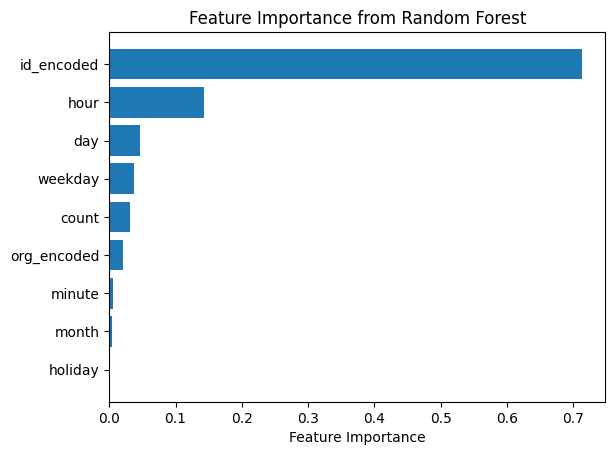

In [19]:
# 특성 중요도 시각화
indices = np.argsort(importances) # 오름차순정렬

# importances와 x_train.columns을 정렬된 순서대로 재배치
sorted_importances = importances[indices]
sorted_features = x_train.columns[indices]

# 막대 그래프 그리기
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest')
plt.show()

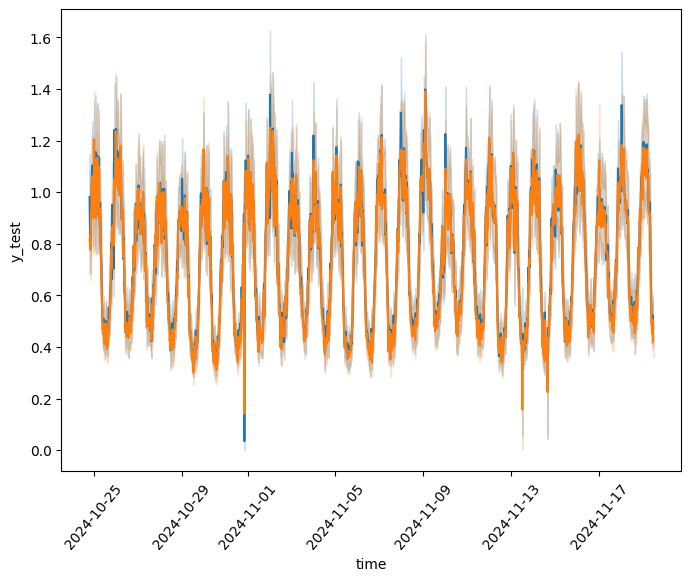

In [20]:
# 시각화
plt.figure(figsize=(8,6))
sns.lineplot(x='time' , y='y_test', data=df)
sns.lineplot(x='time' , y='y_pred', data=df)
plt.xticks(rotation=50)
plt.show()

# blue: test / orange: predict

#### 머신러닝 모델 예측 결과 시각화
이는 시계열 데이터에서 자주 발생하는 계절성(seasonality)과 추세(trend)를 잘 반영한 결과이다.

1. 계절성 (Seasonality)
계절성은 데이터에서 특정 기간마다 규칙적으로 반복되는 패턴.
예를 들어, 시간대별로 충전 수요가 증가하거나 감소하는 패턴이 있을 수 있다.
이는 하루 중 특정 시간대에 충전소를 이용하려는 수요가 몰리는 경우, 혹은 주말과 평일에 수요 차이가 나는 경우 등에서 발생할 수 있다.

시간대별 수요: 예를 들어, 출퇴근 시간대(아침, 저녁)에 충전소 수요가 급증하거나, 주중과 주말 사이에 수요 차이가 나타날 수 있다.
주기적인 변화: 특정 계절에 따라 충전 수요가 달라지는 경향이 있을 수 있다. 예를 들어, 겨울철에는 차량의 배터리 효율이 낮아져 충전 수요가 증가하는 등의 현상.
모델이 시간이 지나면서 규칙적으로 반복되는 패턴을 보인다면, 이는 계절성을 잘 포착한 것으로, 시간의 흐름에 따라 충전 수요가 반복적인 주기성을 따르고 있다는 것을 의미한다.

2. 추세 (Trend)
추세는 시간이 지나면서 데이터의 전반적인 방향성이 변하는 패턴을 의미한다. 예를 들어, 전기차 사용자가 증가함에 따라 충전소의 수요가 지속적으로 증가하는 현상이다.

수요 증가 추세: 전기차가 점차 보급되어 충전 수요는 시간이 지남에 따라 꾸준히 증가할 가능성이 크다.
산업 발전: 충전소의 인프라가 확장되고, 충전 속도가 빨라지거나 충전소의 접근성이 향상되면, 추세적으로 수요가 더욱 증가할 수 있다.
예측 모델이 시각화에서 시간에 따라 점진적으로 증가하는 패턴을 보였다면, 이는 추세를 잘 반영한 결과일 수 있다.

3. 모델에서의 계절성 & 추세 반영
계절성 반영: ARIMA 모델이나 SARIMA(계절성 ARIMA) 모델은 계절성과 추세를 모두 반영할 수 있는 모델이다.
추세 반영: 모델이 시간의 흐름에 따라 수요의 증가나 감소를 잘 예측한다면, 이는 추세를 고려한 예측이 잘 이루어진 것이다.
예를 들어, LSTM(장기 단기 기억) 모델은 시간에 따른 추세와 계절성을 학습하는 데 효과적일 수 있다.

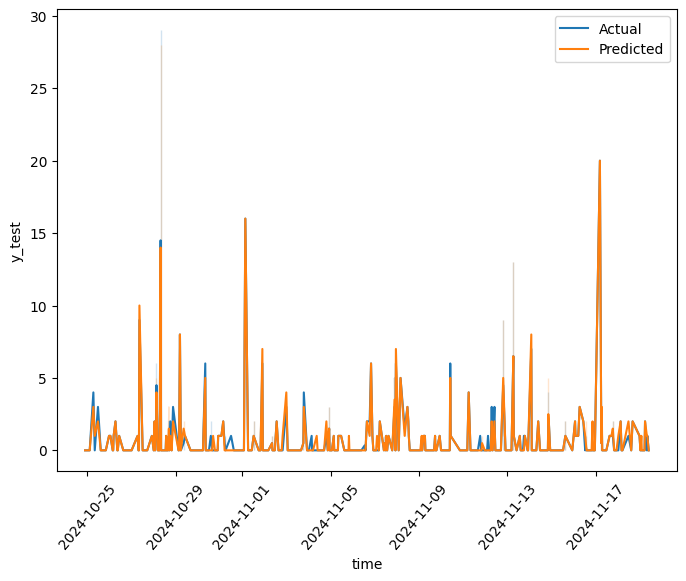

In [21]:
# 일정 간격으로 데이터 샘플링 (예: 2471개마다 하나씩 선택)
df_resampled = df.iloc[::2471, :]

plt.figure(figsize=(8,6))
sns.lineplot(x='time', y='y_test', data=df_resampled, label='Actual')
sns.lineplot(x='time', y='y_pred', data=df_resampled, label='Predicted')
plt.xticks(rotation=50)
plt.show()

#### 교차 검증으로 최적의 하이퍼파라미터를 찾고, 해당 하이퍼파라미터로 모델을 학습한 후 예측과 성능 평가를 수행하는 코드

In [ ]:
# # count 변수 저장하기
# count = df_all.iloc[0, 0]

# # target(예측할 열) 설정하기
# target = 'visitNum'

# # x, y 값 설정하기
# x = df_all.drop(target, axis=1)
# y = df_all[target]

# # 훈련/테스트 데이터 분할 (기존처럼)
# x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=0)

# # 랜덤포레스트 모델 초기화
# model = RandomForestRegressor(random_state=0, n_jobs=-1)

# # 하이퍼파라미터 그리드 설정 (교차 검증을 위한 파라미터 범위)
# param_grid = {
#     'n_estimators': [50, 100, 200],    # 트리 개수
#     'max_depth': [10, 20, 30, None],    # 트리의 최대 깊이
#     'min_samples_split': [2, 5, 10],    # 분할할 최소 샘플 수
#     'min_samples_leaf': [1, 2, 4],      # 리프 노드에 필요한 최소 샘플 수
#     'max_features': ['auto', 'sqrt', 'log2'],  # 각 트리에서 선택할 특성의 수
# }

# # GridSearchCV 사용: 교차 검증을 통해 하이퍼파라미터 튜닝
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)

# # GridSearchCV로 학습
# grid_search.fit(x_train, y_train)

# # 최적의 하이퍼파라미터 출력
# print("Best parameters found: ", grid_search.best_params_)

# # 최적의 모델로 예측
# best_model = grid_search.best_estimator_

# # 모델 예측
# y_pred = best_model.predict(x_test)

# # 예측 결과 반올림
# y_pred = np.round(y_pred)

# # 정확도 출력 (R2 score)
# print(f"R2 score: {r2_score(y_test, y_pred)}")

# # 모델 정확도 (score method)
# acc = best_model.score(x_test, y_test)
# print(f"Model accuracy (R^2 score): {acc}")

# # 시각화를 위한 df 형식으로 변환
# y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'])
# y_test_df = pd.DataFrame(y_test).reset_index(drop=True)

# # 예측값과 실제값을 합치기
# df = pd.concat([y_test_df, y_pred_df], axis=1)
# df.columns = ['y_test', 'y_pred']

# # 결과 출력
# df.head()

#### K-폴드 교차 검증 (K-Fold Cross-Validation)
- 과적합 방지, 일반화 성능 평가

In [25]:
# count 변수 저장하기
count = df_all.iloc[0, 0]

# target(예측할 열) 설정하기
target = 'visitNum'

# x, y 값 설정하기
x = df_all.drop(target, axis=1)
y = df_all[target]

# KFold 교차 검증 설정 (예: 5개의 폴드)
kf = KFold(n_splits=5, shuffle=True, random_state=0)

model = RandomForestRegressor(random_state=0, n_jobs=-1)

# K-폴드 교차 검증 수행
fold = 1
results = []

for train_index, test_index in kf.split(x):
    # 훈련/테스트 데이터 나누기
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # 모델 학습
    model.fit(x_train, y_train)

    # 예측
    y_pred = model.predict(x_test)
    y_pred = np.round(y_pred)

    # 평가 지표 (R²) 계산
    r2 = r2_score(y_test, y_pred)
    results.append(r2)

    # 시각화를 위한 결과 저장 (DataFrame 형식)
    y_pred_df = pd.DataFrame(y_pred)
    y_test_df = pd.DataFrame(y_test)
    y_test_df.reset_index(inplace=True)

    fold_df = pd.concat([y_test_df, y_pred_df], axis=1)
    fold_df.columns = ['time', 'y_test', 'y_pred']
    fold_df['fold'] = fold  # 각 폴드 번호 추가

    # 결과 출력 (각 폴드에 대한 예측)
    print(f"Fold {fold}: R² = {r2:.4f}")
    print(fold_df.head())  # 각 폴드에서의 예측값 몇 개 출력
    fold += 1

# 교차 검증 전체 결과 출력
print(f"\n교차 검증 평균 R²: {np.mean(results):.4f}")

Fold 1: R² = 0.9497
                 time  y_test  y_pred  fold
0 2024-10-24 19:30:00       0     0.0     1
1 2024-10-24 20:30:00       0     0.0     1
2 2024-10-24 21:30:00       0     0.0     1
3 2024-10-25 00:00:00       0     0.0     1
4 2024-10-25 01:00:00       0     0.0     1
Fold 2: R² = 0.9496
                 time  y_test  y_pred  fold
0 2024-10-24 22:30:00       0     0.0     2
1 2024-10-25 11:30:00       0     0.0     2
2 2024-10-25 14:00:00       0     0.0     2
3 2024-10-25 15:00:00       0     0.0     2
4 2024-10-25 17:30:00       0     0.0     2
Fold 3: R² = 0.9492
                 time  y_test  y_pred  fold
0 2024-10-24 20:00:00       0     0.0     3
1 2024-10-24 23:00:00       0     0.0     3
2 2024-10-24 23:30:00       0     0.0     3
3 2024-10-25 00:30:00       0     0.0     3
4 2024-10-25 02:00:00       0     0.0     3
Fold 4: R² = 0.9496
                 time  y_test  y_pred  fold
0 2024-10-24 22:00:00       0     0.0     4
1 2024-10-25 04:30:00       0     0.0   

#### 실제 데이터로 예측 후 MongoDB에 반영하기 🌟

In [26]:
classes = label_encoder.classes_

In [27]:
def run_ml(i):
    # 시간 단위별 예측 df 생성
    pre_df = pd.date_range(now.date()+ timedelta(days=1) , periods=24 , freq="30min") # 30분 단위로 예측 df 만들기

    pre_df = pd.DataFrame(pre_df) # 데이터 프레임 형태로 변환
    pre_df.columns=['time'] # 열 이름 변경

    id = history_stations['_id'][i]

    pre_df['count'] = count

    # 변수 추가하기
    pre_df['time'] = pd.to_datetime(pre_df['time'])
    pre_df['weekday'] = pre_df['time'].dt.weekday
    pre_df['month'] = pre_df['time'].dt.month
    pre_df['day'] = pre_df['time'].dt.day
    pre_df['hour'] = pre_df['time'].dt.hour
    pre_df['minute'] = pre_df['time'].dt.minute

    kr_holidays = holidays.KR()
    pre_df['holiday'] = pre_df.time.apply(lambda x: 1 if x in kr_holidays else 0)

    pre_df.set_index(keys='time', inplace=True)

    # #### 충전소 종류 추가
    # 'id'의 앞 두 글자만 추출
    id_prefix = id[:2]  # 예: 'AB'

    # 'id_prefix'와 'classes_'에서 동일한 값이 있는 인덱스 찾기
    org_value = np.where(classes == id_prefix)[0]
    pre_df['org_encoded'] = org_value[0]

    #### target encoding을 사용하려고 하는데 각각 target을 i값 별로 다르기 때문에
    pre_df['id_encoded'] = target_means.iloc[i]


    pre_predict = model.predict(pre_df)
    pre_predict= np.round(pre_predict)

    pre_predict = pre_predict.tolist()
    collection = db['demand-info']

    statId = history_stations['_id'][i]
    # 해당 statId를 가진 문서 조회

    # print(id, statId)
    # print(pre_predict)
    existing_doc = collection.find_one({"statId": statId })

    # 문서가 존재하지 않으면 새로운 문서를 추가하고 업데이트
    if existing_doc is None:
        new_doc = { "statId": statId, "demandInfo": { "viewNum": 0, "departsIn30m": [], "hourlyVisitNum": [] } }
        result = collection.insert_one(new_doc)
        print("Added new document")
        #time.sleep(0.1)

    x = collection.update_one(
        {"statId":statId},
        {"$set" : {
            'demandInfo.hourlyVisitNum' : pre_predict
        }
        })

In [28]:
#### 약 20분 소요됨 ㅇㅇ

In [29]:
for i in range(len(history_stations)):
    run_ml(i)

Added new document


#### 하나의 데이터프레임으로 합친 뒤 성능
- RandomForestRegressor(충전소 id => 타겟인코딩 사용) : 0.9396
- RandomForestRegressor(충전소 종류 => 라벨인코딩 사용) : 0.6
- RandomForestRegressor(충전소 id, 종류 둘 다 사용) : 0.9460 👍
    - R-squared: 0.9443
    - Mean Squared Error: 0.1853
    - Root Mean Squared Error: 0.4305
    - Mean Absolute Error: 0.1375
    - 교차 검증 평균 R²: 0.9495

- GridSearchCV 교차 검증을 통해 최적의 하이퍼파라미터 출력한 RandomForestRegressor:

⚠️ 항상 모델의 변수를 변경하면 모델 예측 시 사용되는 데이터프레임의 변수도 변경해주기.

#### k-means로 유사한 특징을 가진 충전소들별로 모델 따로 학습 및 적용하기

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 필요한 열만 선택 (id_encoded는 각 충전소를 구분하는 식별자라고 가정)
features = ['count', 'weekday', 'month', 'day', 'hour', 'minute', 'holiday']

# id_encoded는 각 충전소를 구분하는 변수로, 군집화 과정에 포함하지 않음
X = df_all[features]

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans 모델 설정 (군집의 개수는 필요에 따라 조정)
kmeans = KMeans(n_clusters=10, random_state=42)

# KMeans 모델 학습
df_all['cluster'] = kmeans.fit_predict(X_scaled)

# 군집화 결과 확인
print(df_all[['id_encoded', 'cluster']].head())

In [ ]:
# 각 군집의 중심값(centroids) 확인
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=features)
print("Cluster Centroids:")
print(centroids)

# 각 군집 별로 평균값을 구해서 특징 분석
cluster_means = df_all.groupby('cluster')[features].mean()
print("Cluster Averages:")
print(cluster_means)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 군집화된 데이터를 시각화 (count vs hour)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_all, x='visitNum', y='count', hue='cluster', palette='viridis', s=100, alpha=0.6)
plt.title("KMeans Clustering (visitNum vs count)")
plt.xlabel("visitNum")
plt.ylabel("Count")
plt.show()

In [ ]:
# 각 충전소(id_encoded)별 군집 결과
station_clusters = df_all.groupby('id_encoded')['cluster'].first()
print("Station Clusters:")
print(station_clusters.head())

# 군집별 특징 분석 (각 군집의 특성을 파악)
for cluster_id in range(kmeans.n_clusters):
    cluster_data = df_all[df_all['cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} Characteristics:")
    print(cluster_data[features].mean())